# Laboratorio de Inteligência Artificial e Ciência de Dados
## Project 2024/25 - Lung Cancer Classification
#### Work assembled by Guilherme Santos (202208081)

## Table of contents <a name="contents"></a>

1. [Introduction](#introduction)
2. [Data Extraction](#data-extraction)
3. [Feature Selection](#feature-selection)
4. [Exploratory Data Analysis](#eda)
5. [Classification without oversampling](#cwo)
   - 5.1. [Traditional Random Forest](#rf)
   - 5.2. [Balanced Random Forest](#brf)
   - 5.3. [Support Vector Classifier](#svc)
   - 5.4. [Convolutional Neural Network](#cnn)
   - 5.5. [Ensemble Classifier](#ec)
6. [Classification with oversampling](#co)
   - 6.1. [Traditional Random Forest](#rfo)
   - 6.2. [Balanced Random Forest](#brfo)
   - 6.3. [Support Vector Classifier](#svco)
   - 6.4. [Convolutional Neural Network](#cnno)
   - 6.5. [Ensemble Classifier](#eco)
7. [Models Comparison](#comparison)
8. [Conclusion](#conclusion)

# 1. Introduction <a name="introduction"></a>
[[go back to the top]](#contents)

Lung cancer is onde of the deadliest types of cancer in the world. Only 16% of these are early detection of a malignant nodule which plays a crucial role in the increase of survival rate of lung cancer patients by around **50%**. 

To ease this kind of detection I implemented a **ML workflow** that predicts the malignancy of a nodule by its characteristics. To achieve a decent predictor we used LIDC-IDRI, a known public dataset that contain more than 1000 patients each with multiple CT scans, to train and evaluate each model.

# 2. Data Extraction <a name="data-extraction"></a>
[[go back to the top]](#contents)

In [1]:
import pylidc as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from tensorflow_addons.metrics import F1Score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 



Using **pylidc**, we iterate over LIDC-IDRI scans, cluster per-scan annotations into nodules and aggregate each nodule’s radiologist attributes across annotations (min/mean/max).

The resulting feature table includes: Diameter, Surface Area, Calcification, Internal Structure, Lobulation, Margin, Spiculation, Subtlety, Texture, Volume, Centroid, Sphericity, and Malignancy (all as min/mean/max), plus Patient ID, Nodule ID, and Number of Nodules. The table is stored as a CSV for downstream analysis.

In [ ]:
#Query for all scans from LIDC-IDRI
scans = pl.query(pl.Scan).all()

features = []

#Iterate through each scan
for scan in scans:

    #Cluster the annotations of the scan
    nodules = scan.cluster_annotations()

    #Get the number of nodules in the scan
    number_nodes=len(nodules)


    #Iterate through each nodule
    for nodule_index, nodule in enumerate(nodules):

        #Calculate the diameter of the nodule (minimum, average and max of all annotations)
        diameter_scores = [ann.diameter for ann in nodule]
        diameter_min = np.min(diameter_scores)
        diameter_mean = np.mean(diameter_scores)
        diameter_max = np.max(diameter_scores)

        #Calculate the surface area of the nodule (minimum, average and max of all annotations)
        surface_area_scores = [ann.surface_area for ann in nodule]
        surface_area_min = np.min(surface_area_scores)
        surface_area_mean = np.mean(surface_area_scores)
        surface_area_max = np.max(surface_area_scores)

        #Calculate the sphericity of the nodule (minimum, average and max of all annotations)
        sphericity_scores = [ann.sphericity for ann in nodule]
        sphericity_min = np.min(sphericity_scores)
        sphericity_mean = np.mean(sphericity_scores)
        sphericity_max = np.max(sphericity_scores)

        #Calculate the centroid of the nodule (minimum, average and max of all annotations)
        centroid_scores = [ann.centroid for ann in nodule]
        centroid_min = np.min(centroid_scores)
        centroid_mean = np.mean(centroid_scores)
        centroid_max = np.max(centroid_scores)

        #Calculate the volume of the nodule (minimum, average and max of all annotations)
        volume_scores = [ann.volume for ann in nodule]
        volume_min = np.min(volume_scores)
        volume_mean = np.mean(volume_scores)
        volume_max = np.max(volume_scores)

        #Calculate the texture of the nodule (minimum, average and max of all annotations)
        texture_scores = [ann.texture for ann in nodule]
        texture_min = np.min(texture_scores)
        texture_mean = np.mean(texture_scores)
        texture_max = np.max(texture_scores)

        #Calculate the subtlety of the nodule (minimum, average and max of all annotations)
        subtlety_scores = [ann.subtlety for ann in nodule]
        subtlety_min = np.min(subtlety_scores)
        subtlety_mean = np.mean(subtlety_scores)
        subtlety_max = np.max(subtlety_scores)

        #Calculate the spiculation of the nodule (minimum, average and max of all annotations)
        spiculation_scores = [ann.spiculation for ann in nodule]
        spiculation_min = np.min(spiculation_scores)
        spiculation_mean = np.mean(spiculation_scores)
        spiculation_max = np.max(spiculation_scores)

        #Calculate the margin of the nodule (minimum, average and max of all annotations)
        margin_scores = [ann.margin for ann in nodule]
        margin_min = np.min(margin_scores)
        margin_mean = np.mean(margin_scores)
        margin_max = np.max(margin_scores)

        #Calculate the malignacy of the nodule (minimum, average and max of all annotations)
        malignancy_scores = [ann.malignancy for ann in nodule]
        malignancy_min = np.min(malignancy_scores)
        malignancy_mean = np.mean(malignancy_scores)
        malignancy_max = np.max(malignancy_scores)

        #Calculate the lobulation of the nodule (minimum, average and max of all annotations)
        lobulation_scores = [ann.lobulation for ann in nodule]
        lobulation_min = np.min(lobulation_scores)
        lobulation_mean = np.mean(lobulation_scores)
        lobulation_max = np.max(lobulation_scores)

        #Calculate the internal strucutre of the nodule (minimum, average and max of all annotations)
        internal_structure_scores = [ann.internalStructure for ann in nodule]
        internal_structure_min = np.min(internal_structure_scores)
        internal_structure_mean = np.mean(internal_structure_scores)
        internal_structure_max = np.max(internal_structure_scores)

        #Calculate the calcification of the nodule (minimum, average and max of all annotations)
        calcification_scores = [ann.calcification for ann in nodule]
        calcification_min = np.min(calcification_scores)
        calcification_mean = np.mean(calcification_scores)
        calcification_max = np.max(calcification_scores)

        #Append extracted data from the nodule to the features list
        features.append({
            "Patient ID": scan.patient_id,
            "Nodule ID": nodule_index + 1,  #Nodule ID from each patient
            "Number of Nodules": number_nodes,  #Number of nodules in the scan

            #Diameter
            "Min Diameter": diameter_min,
            "Mean Diameter": diameter_mean,
            "Max Diameter": diameter_max,

            #Surface Area
            "Min Surface Area": surface_area_min,
            "Mean Surface Area": surface_area_mean,
            "Max Surface Area": surface_area_max,

            #Calcification 
            "Min Calcification": calcification_min,
            "Mean Calcification": calcification_mean,
            "Max Calcification": calcification_max,

            #Internal Structure
            "Min Internal Structure": internal_structure_min,
            "Mean Internal Structure": internal_structure_mean,
            "Max Internal Structure": internal_structure_max,

            #Lobulation
            "Min Lobulation": lobulation_min,
            "Mean Lobulation": lobulation_mean,
            "Max Lobulation": lobulation_max,

            #Margin
            "Min Margin": margin_min,
            "Mean Margin": margin_mean,
            "Max Margin": margin_max,

            #Spiculation
            "Min Spiculatation": spiculation_min,
            "Mean Spiculation": spiculation_mean,
            "Max Spiculation": spiculation_max,

            #Subtlety
            "Min Subtlety": subtlety_min,
            "Mean Subtlety": subtlety_mean,
            "Max Subtlety": subtlety_max,

            #Texture
            "Min Texture": texture_min,
            "Mean Texture": texture_mean,
            "Max Texture": texture_max,

            #Volume
            "Min Volume": volume_min,
            "Mean Volume": volume_mean,
            "Max Volume": volume_max,

            #Centroid
            "Min Centroid": centroid_min,
            "Mean Centroid": centroid_mean,
            "Max Centroid": centroid_max,

            #Sphericity
            "Min Sphericity": sphericity_min,
            "Mean Sphericity": sphericity_mean,
            "Max Sphericity": sphericity_max,

            #Malignancy
            "Min Malignancy": malignancy_min,
            "Mean Malignancy": malignancy_mean,
            "Max Malignancy": malignancy_max
        })


df = pd.DataFrame(features)

df_path = r'C:\Users\Gui\Documents\Uni\LIACD\Trabalho\pylidc_feature_extraction.csv'
df.to_csv(df_path, index=False)

Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some nodules may be close and must be grouped manually.
Failed to reduce all groups to <= 4 Annotations.
Some n

# 3. Feature Selection <a name="feature-selection"></a>
[[go back to the top]](#contents)

To define a binary target **Malignancy**, I studied the distribution of Min Malignacy, Mean Malignancy and Max Malignancy. Since the almost every nodule stays between ]2, 4[, I concluded that a save option would be mean if Mean Malignancy ≥ 3.5 or Max Malignancy = 5. 

After standardization, three complementary selectors identify predictive features:
- SelectKBest;
- RFE with Logistic Regression
- Random Forest feature importances.

The union of top-k features from these methods forms the working feature set, which is validated for consistency and saved as a compact dataset.

Axes(0.125,0.11;0.775x0.77)




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



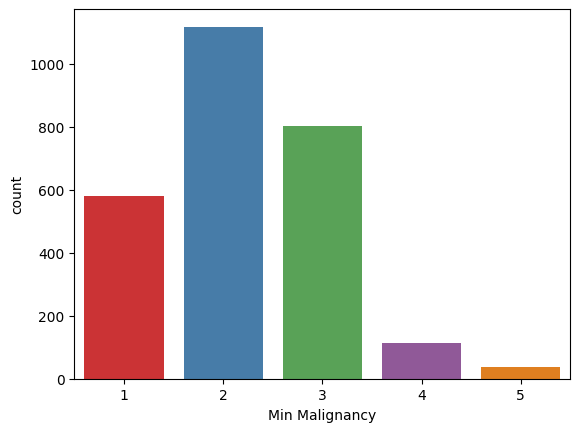

In [ ]:
print(sns.countplot(x='Min Malignancy',data=df, palette='Set1'))

Axes(0.125,0.11;0.775x0.77)


Ignoring `palette` because no `hue` variable has been assigned.


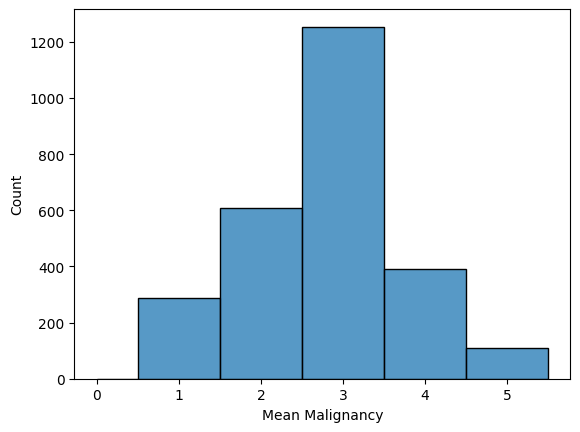

In [ ]:
print(sns.histplot(x='Mean Malignancy',data=df,bins=[0,0.5,1.5,2.5,3.5,4.5,5.5], palette='Set1'))

Axes(0.125,0.11;0.775x0.77)




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



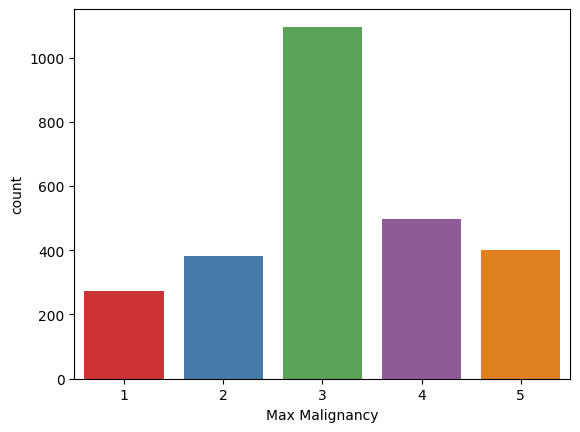

In [ ]:
print(sns.countplot(x='Max Malignancy',data=df, palette='Set1'))

In [ ]:
#Separate the target
X = df.drop(columns=["Patient ID", "Nodule ID", "Mean Malignancy", "Max Malignancy", "Min Malignancy"])

#Target variable
df["Malignancy"]=np.where((df["Mean Malignancy"]>= 3.5)|(df["Max Malignancy"]==5), True, False)
y = df["Malignancy"]

#Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Feature selection using SelectKBest
k_best = SelectKBest(score_func=f_classif, k=10)  # Choose top 10 features
X_kbest = k_best.fit_transform(X_scaled, y)

#Get selected feature names
selected_kbest = X.columns[k_best.get_support()]

#Feature selection using RFE
log_reg = LogisticRegression(max_iter=1000)
rfe = RFE(log_reg, n_features_to_select=10)  # Select top 10 features
X_rfe = rfe.fit_transform(X_scaled, y)
selected_rfe = X.columns[rfe.get_support()]

#Feature selection using RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)
importances = rf.feature_importances_

#Sort features by importance and select the top 10
indices = np.argsort(importances)[-10:]
selected_rf = X.columns[indices]

#Use a set to store unique features
unique_features = set()
unique_features.update(selected_kbest)
unique_features.update(selected_rfe)
unique_features.update(selected_rf)
unique_features = [feature for feature in X.columns if feature in unique_features]

df_output = df[["Patient ID", "Nodule ID"] + unique_features].copy()
df_output['Malignancy'] = y  # Add the target variable

#Check for value mismatches
mismatch_report = []

for feature in unique_features:
    if feature in df.columns:
        original_values = df[feature]
        output_values = df_output[feature]
        
        # Check for mismatches
        mismatched_indices = original_values[original_values != output_values].index.tolist()
        
        if mismatched_indices:
            mismatch_report.append({
                "Feature": feature,
                "Mismatch Indices": mismatched_indices,
                "Original Values": original_values[mismatched_indices].tolist(),
                "Output Values": output_values[mismatched_indices].tolist(),
            })

if mismatch_report:
    print("Value mismatches found:")
    for mismatch in mismatch_report:
        print(f"Feature: {mismatch['Feature']}")
        print(f"Mismatch Indices: {mismatch['Mismatch Indices']}")
        print(f"Original Values: {mismatch['Original Values']}")
        print(f"Output Values: {mismatch['Output Values']}")
        print("---")
else:
    print("No value mismatches found between the original DataFrame and the output DataFrame.")

df_output_path = r'C:\Users\Gui\Documents\Uni\LIACD\Trabalho\pylidc_selected_features_with_target.csv'
df_output.to_csv(df_output_path, index=False)

No value mismatches found between the original DataFrame and the output DataFrame.


# 4. Exploratory Data Analysis (EDA) <a name="eda"></a>
[[go back to the top]](#contents)

In this section, I explore data types, missingness, distributions, correlations, and class balance. Heatmaps to expose multicollinearity, histograms and count plots to show spread and skew, guiding feature selection and model choice.

In [ ]:
df=pd.read_csv(r'C:\Users\Gui\Documents\Uni\LIACD\Trabalho\pylidc_selected_features_with_target.csv')
df.head(5)

,Patient ID,Nodule ID,Min Diameter,Mean Diameter,Max Diameter,Min Surface Area,Mean Surface Area,Max Surface Area,Mean Calcification,Max Calcification,...,Max Lobulation,Max Spiculation,Min Subtlety,Mean Subtlety,Max Subtlety,Mean Texture,Min Volume,Mean Volume,Max Volume,Malignancy
0,LIDC-IDRI-0078,1,19.500000,23.945243,27.980216,1035.254928,1193.424473,1360.254889,6.0,6,...,4,4,4,4.50,5,4.75,2260.586250,2516.304375,2703.577500,True
1,LIDC-IDRI-0078,2,17.501786,20.694395,23.544001,777.536323,1018.748994,1130.172711,6.0,6,...,4,4,4,4.75,5,4.50,1510.226250,2193.250312,2443.740000,True
2,LIDC-IDRI-0078,3,5.076662,5.076662,5.076662,66.910605,66.910605,66.910605,5.0,5,...,1,1,4,4.00,4,5.00,62.107500,62.107500,62.107500,False
3,LIDC-IDRI-0078,4,23.300483,27.694350,32.810517,1650.898027,1870.264307,1994.684094,5.0,6,...,4,4,5,5.00,5,4.75,4332.315000,4870.685625,5365.961250,True
4,LIDC-IDRI-0069,1,9.284703,12.648800,18.226190,228.703978,401.426716,521.668568,6.0,6,...,5,5,2,2.50,3,4.75,271.795095,585.183076,803.854584,True


In [ ]:
print("Data Types:\n", df.dtypes)

Data Types:
 Patient ID                 object
Nodule ID                   int64
Min Diameter              float64
Mean Diameter             float64
Max Diameter              float64
Min Surface Area          float64
Mean Surface Area         float64
Max Surface Area          float64
Mean Calcification        float64
Max Calcification           int64
Min Internal Structure      int64
Max Lobulation              int64
Max Spiculation             int64
Min Subtlety                int64
Mean Subtlety             float64
Max Subtlety                int64
Mean Texture              float64
Min Volume                float64
Mean Volume               float64
Max Volume                float64
Malignancy                   bool
dtype: object


In [ ]:
print("Missing Values:\n", df.isnull().sum())

Missing Values:
 Patient ID                0
Nodule ID                 0
Min Diameter              0
Mean Diameter             0
Max Diameter              0
Min Surface Area          0
Mean Surface Area         0
Max Surface Area          0
Mean Calcification        0
Max Calcification         0
Min Internal Structure    0
Max Lobulation            0
Max Spiculation           0
Min Subtlety              0
Mean Subtlety             0
Max Subtlety              0
Mean Texture              0
Min Volume                0
Mean Volume               0
Max Volume                0
Malignancy                0
dtype: int64


In [13]:
print('Number of patients')
print(df["Patient ID"].nunique())

Number of patients
875




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



<Axes: xlabel='Number of Nodules', ylabel='count'>

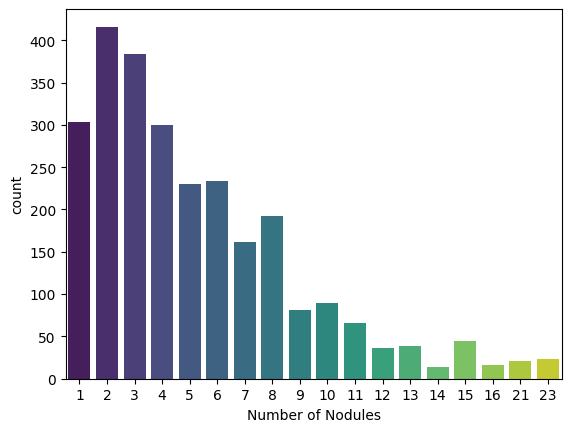

In [ ]:
data = pd.read_csv(r'C:\Users\Gui\Documents\Uni\LIACD\Trabalho\pylidc_feature_extraction.csv')
sns.countplot(x='Number of Nodules', data=data, palette="viridis")

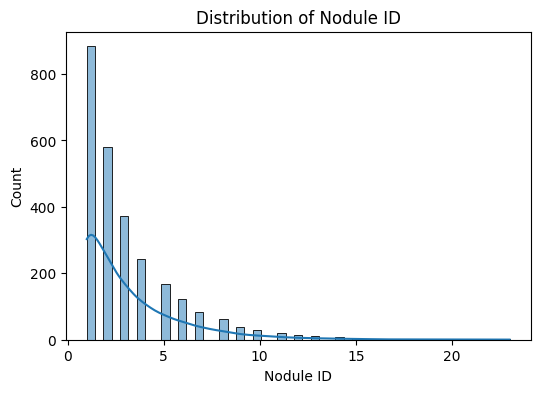

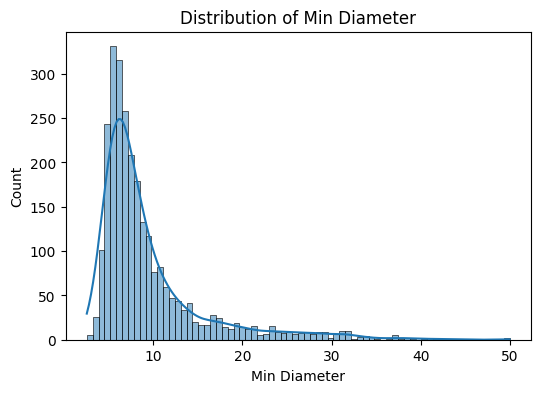

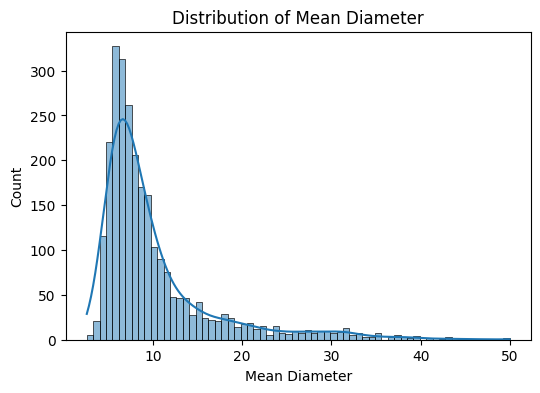

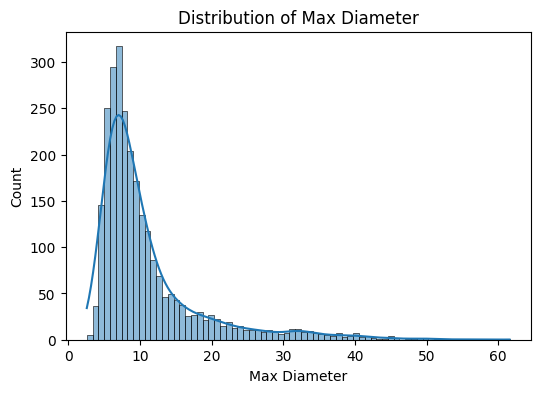

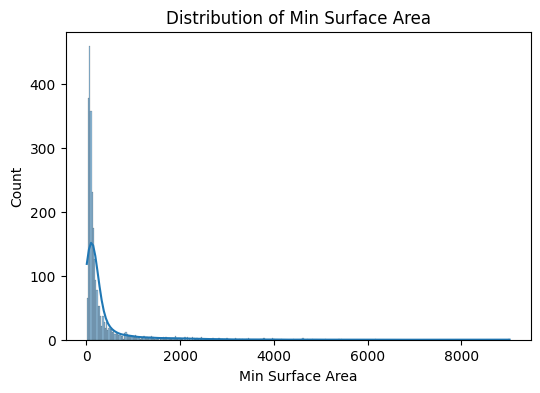

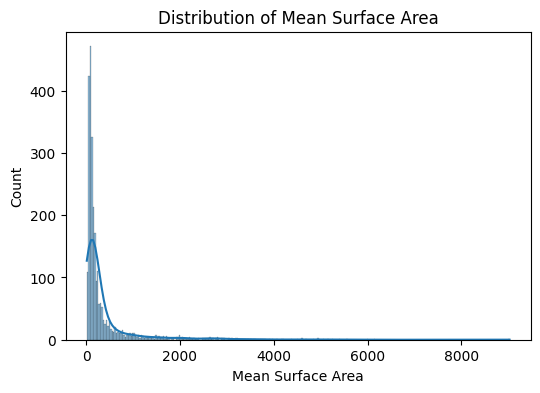

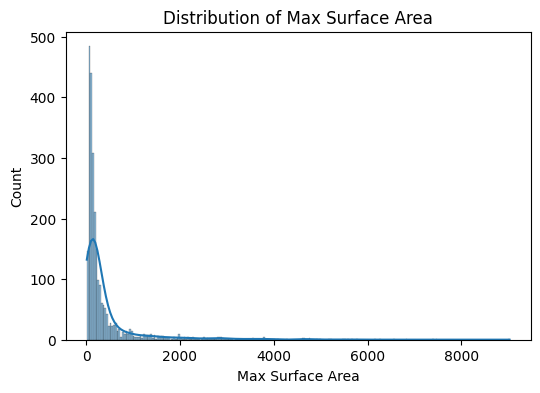

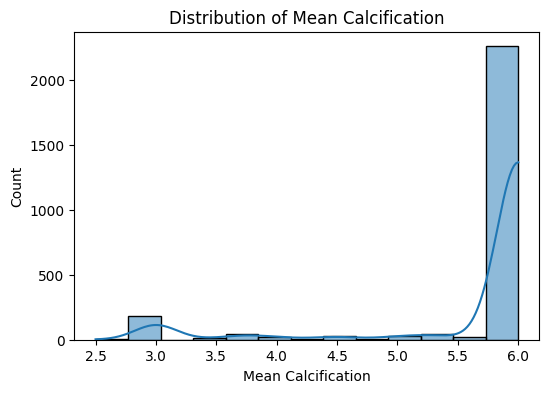

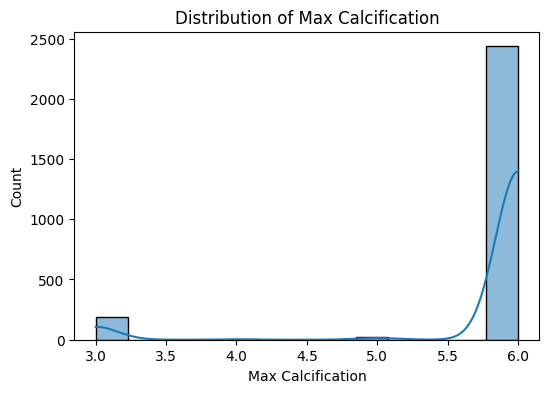

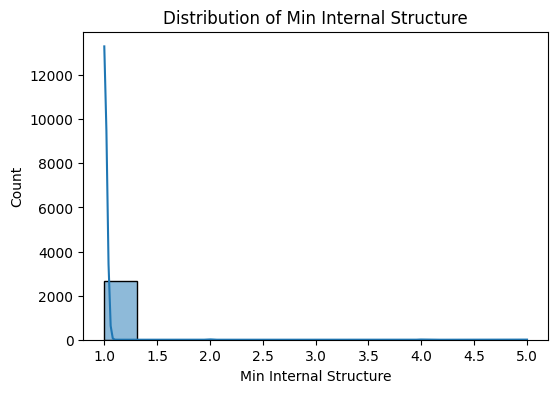

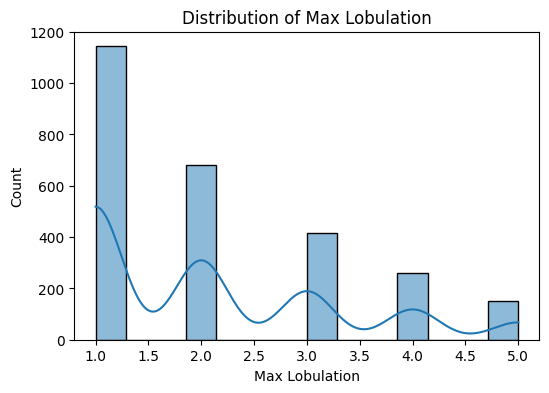

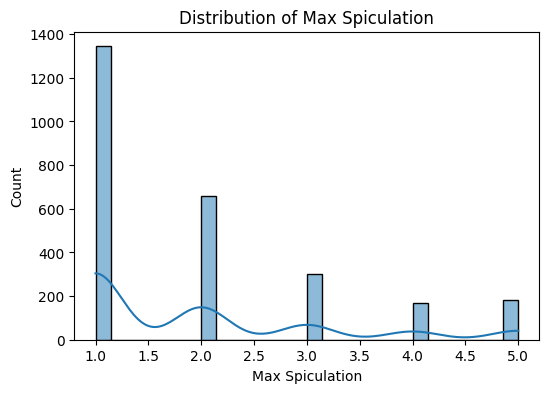

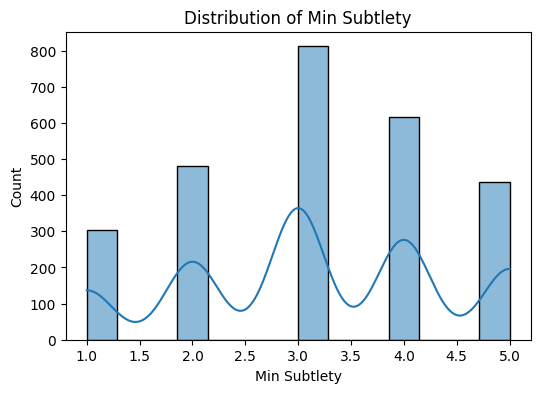

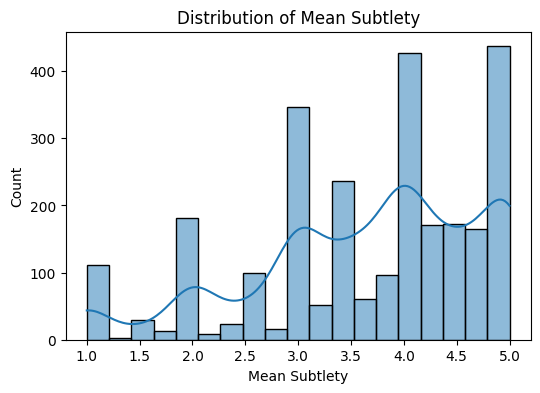

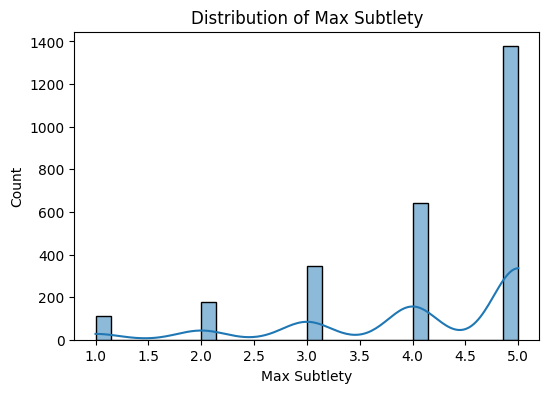

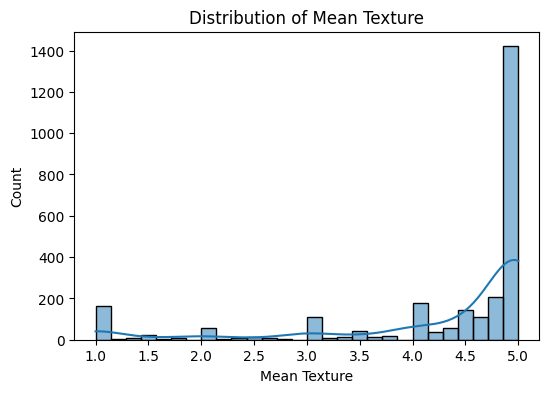

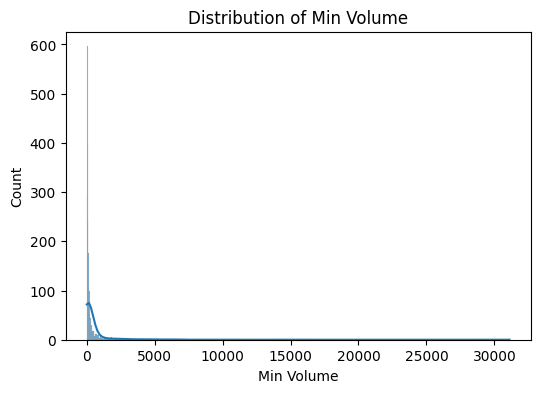

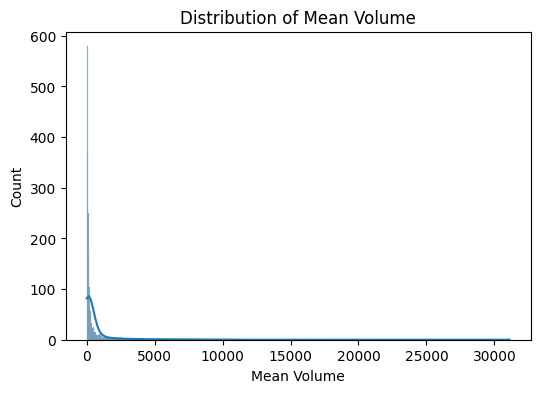

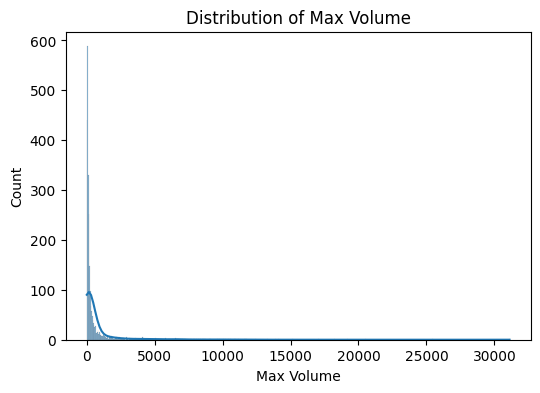

In [ ]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
for column in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f"Distribution of {column}")
    plt.show()

This heatmap exposes which features should be more important to the model to predict the malignancy of the nodule. As its shown, every space measurement (Diameter, Surface Area and Volume) are strongly correlated to the malignancy.

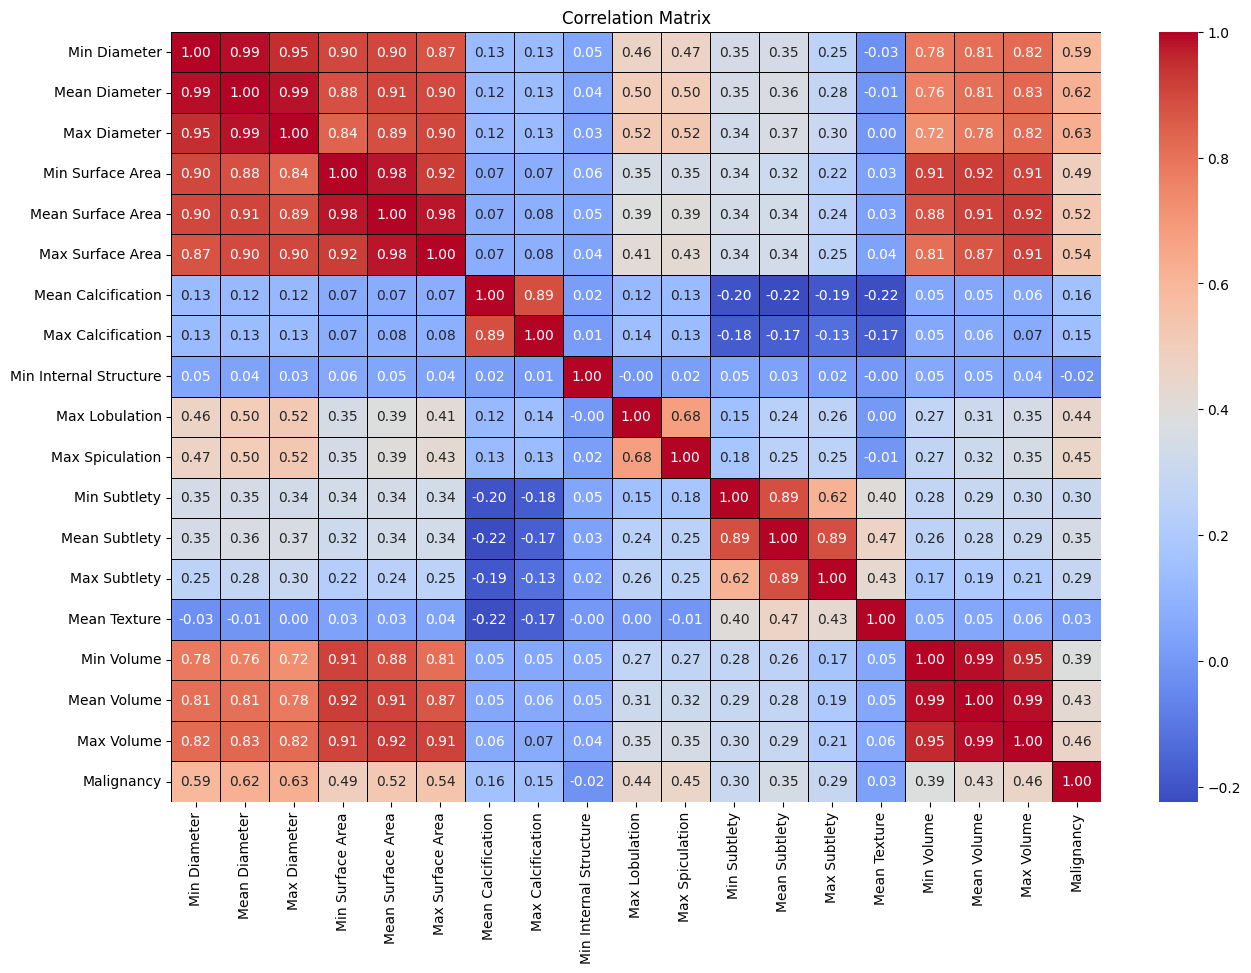

In [ ]:
plt.figure(figsize=(15, 10))
sns.heatmap(df.drop(columns = ['Patient ID', 'Nodule ID']).corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, linecolor='black')
plt.title("Correlation Matrix")
plt.show()

To determine which evaluation metric should be used, I explored the distribution of the malignancy. As we can see, it heavily imbalanced.

Axes(0.125,0.11;0.775x0.77)




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



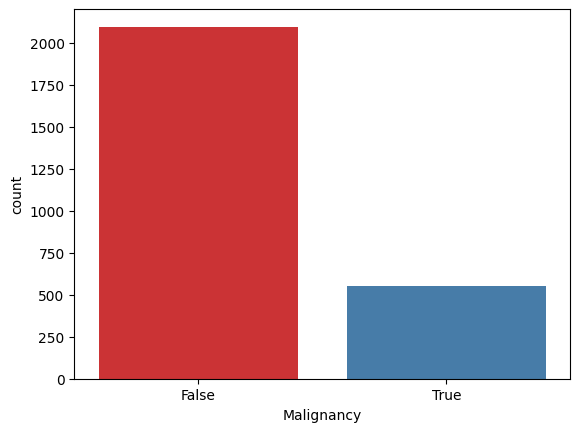

In [ ]:
print(sns.countplot(x='Malignancy', data=df, palette="Set1"))

# 5. Classification without oversampling <a name="cwo"></a>
[[go back to the top]](#contents)

We split the data into train/test sets and use stratified 8-fold CV for tuning (where applicable). Models are evaluated on the untouched test set with F1, ROC-AUC, PR-AUC, confusion matrices, and full classification reports.

In [ ]:
X = df.drop(columns=["Patient ID", "Nodule ID", "Malignancy"])  # Features
y = df["Malignancy"]  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=42)

## 5.1 Traditional Random Forest Classifier without oversampling <a name="rf"></a>
[[go back to the top]](#contents)

I train a baseline **Random Forest** classifier on the selected radiomics/features **without oversampling**.
- **Inputs:** `X_train`, `y_train` from the previous split; feature set defined in Section 3.
- **Model & key hyperparameters:** Grid over `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`, and `max_features` (see code cell). Class weights are left default for this baseline.
- **Validation & metrics:** Stratified split; report **ROC‑AUC, F1, precision, recall, accuracy**, and show the **confusion matrix**. SHAP **TreeExplainer** is used to rank features.
- **Outputs/artifacts:** Best params and scores printed; plots for SHAP summary and confusion matrix rendered inline.
- **How to tweak:** Edit the `param_grid` and `random_state`; to speed up, reduce `n_estimators`.

[[go back to the top]](#contents)

In [ ]:
rf = RandomForestClassifier(random_state=42)

In [ ]:
param_grid = {
    'class_weight': ['balanced', 'balanced_subsample'],
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

best_rf = grid_search_rf.best_estimator_

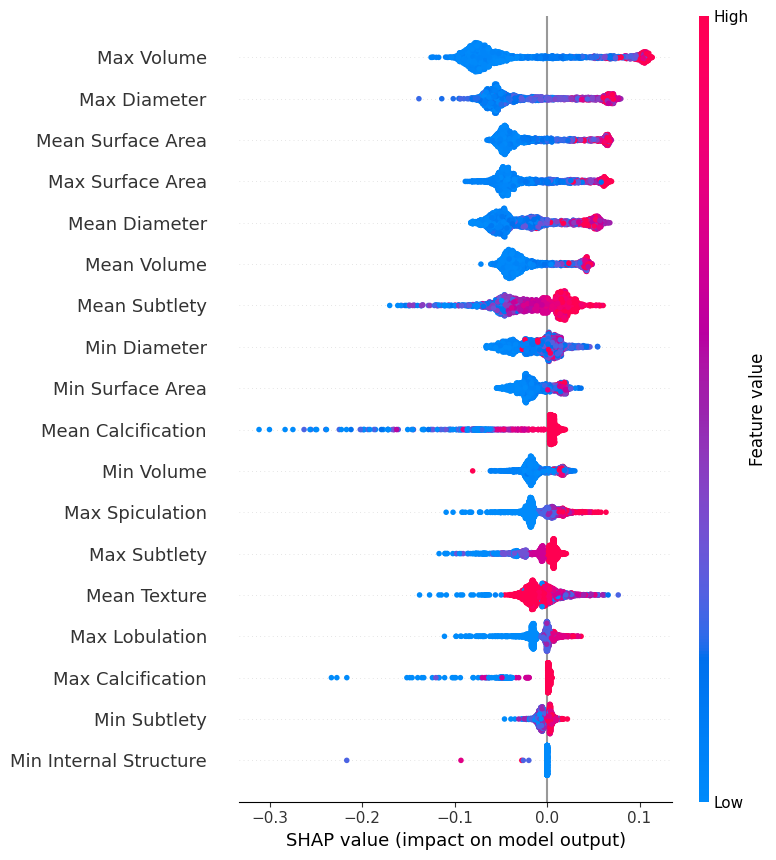

In [ ]:
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values[1], X_train, plot_type="dot", color=plt.get_cmap("coolwarm"))

In [ ]:
rf_conf_matrix = confusion_matrix(y_test, best_rf.predict(X_test))
rf_class_report = classification_report(y_test, best_rf.predict(X_test))

rf_test_auc_roc = roc_auc_score(y_test, best_rf.predict(X_test))

 
precision, recall, _ = precision_recall_curve(y_test, best_rf.predict(X_test))
rf_pr_auc = auc(recall, precision)

 
rf_f1 = f1_score(y_test, best_rf.predict(X_test))

print("Best parameters:", grid_search_rf.best_params_)
print("\n")
print("Confusion Matrix:")
print(rf_conf_matrix)
print("\n")
print("Classification Report:")
print(rf_class_report)
print("Test F1 Score:", rf_f1)
print("Test AUC-ROC Score:", rf_test_auc_roc)
print("Test PR AUC:", rf_pr_auc)

Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


Confusion Matrix:
[[384  32]
 [ 24  91]]


Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.92      0.93       416
        True       0.74      0.79      0.76       115

    accuracy                           0.89       531
   macro avg       0.84      0.86      0.85       531
weighted avg       0.90      0.89      0.90       531

Test F1 Score: 0.7647058823529412
Test AUC-ROC Score: 0.8571906354515051
Test PR AUC: 0.7881697431565325


## 5.2 Balanced Random Forest Classifier without oversampling <a name="brf"></a>
[[go back to the top]](#contents)

I fit **Balanced Random Forest** without **oversampling**
- **Inputs:** `X_train`, `y_train`.
- **Model & key hyperparameters:** `BalancedRandomForestClassifier` with tuned `n_estimators`/`max_depth`.
- **Validation & metrics:** Evaluate on held‑out test set with **ROC‑AUC, F1, precision, recall**, and confusion matrix; analyze SHAP feature impacts.
- **Outputs/artifacts:** Best configuration and metrics displayed.


In [ ]:
brf = BalancedRandomForestClassifier(random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'sampling_strategy': ['auto', 0.5, 0.75, 1.0],
    'replacement': [True, False]
}

grid_search_brf = GridSearchCV(estimator=brf, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1)
grid_search_brf.fit(X_train, y_train)

best_brf = grid_search_brf.best_estimator_


3072 fits failed out of a total of 12288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3072 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gui\anaconda3\envs\pyradiomics_env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gui\anaconda3\envs\pyradiomics_env\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Gui\anaconda3\envs\pyradiomics_env\lib\site-packages\imblearn\ensemble\_forest.py", line 706, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimatio

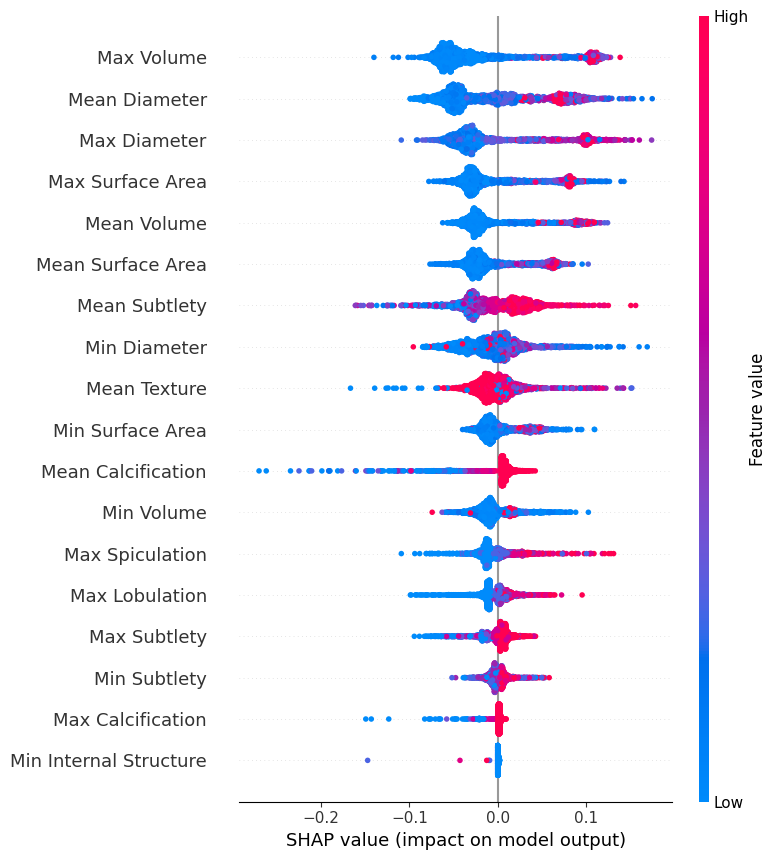

In [ ]:
explainer = shap.TreeExplainer(best_brf)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values[1], X_train, plot_type="dot", color=plt.get_cmap("coolwarm"))

In [ ]:
brf_conf_matrix = confusion_matrix(y_test, best_brf.predict(X_test))
brf_class_report = classification_report(y_test, best_brf.predict(X_test))

brf_test_auc_roc = roc_auc_score(y_test, best_brf.predict(X_test))

precision, recall, _ = precision_recall_curve(y_test, best_brf.predict(X_test))
brf_pr_auc = auc(recall, precision)

brf_f1 = f1_score(y_test, best_brf.predict(X_test))

print("Best parameters:", grid_search_brf.best_params_)
print("\n")
print("Confusion Matrix:")
print(brf_conf_matrix)
print("\n")
print("Classification Report:")
print(brf_class_report)
print("Test F1 Score:", brf_f1)
print("Test AUC-ROC Score:", brf_test_auc_roc)
print("Test PR AUC:", brf_pr_auc)

Best parameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 50, 'oob_score': False, 'replacement': False, 'sampling_strategy': 0.5}


Confusion Matrix:
[[381  35]
 [ 21  94]]


Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.92      0.93       416
        True       0.73      0.82      0.77       115

    accuracy                           0.89       531
   macro avg       0.84      0.87      0.85       531
weighted avg       0.90      0.89      0.90       531

Test F1 Score: 0.7704918032786885
Test AUC-ROC Score: 0.8666283444816054
Test PR AUC: 0.7928107487446658


Support Vector Classifier without Oversampling

## 5.3 Support Vector Classifier without oversampling <a name="svc"></a>
[[go back to the top]](#contents)

#### Overview
- **What this section does:** Train **SVC** without **oversampling**.
- **Inputs:** `X_train`, `y_train` for training; evaluation on original `X_test`, `y_test`.
- **Model & key hyperparameters:** Grid over `C`, `gamma`, and kernel; standardize features before fitting.
- **Validation & metrics:** Report **ROC‑AUC, F1, precision, recall**; include confusion matrix.
- **Outputs/artifacts:** Best hyperparameters and metrics printed.


In [ ]:
svc = SVC(random_state=42)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}

grid_search_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1, verbose=2)
grid_search_svc.fit(X_train, y_train)

best_svc = grid_search_svc.best_estimator_

print("Best parameters:", grid_search_svc.best_params_)

Fitting 8 folds for each of 12 candidates, totalling 96 fits
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}


  0%|          | 0/200 [00:00<?, ?it/s]

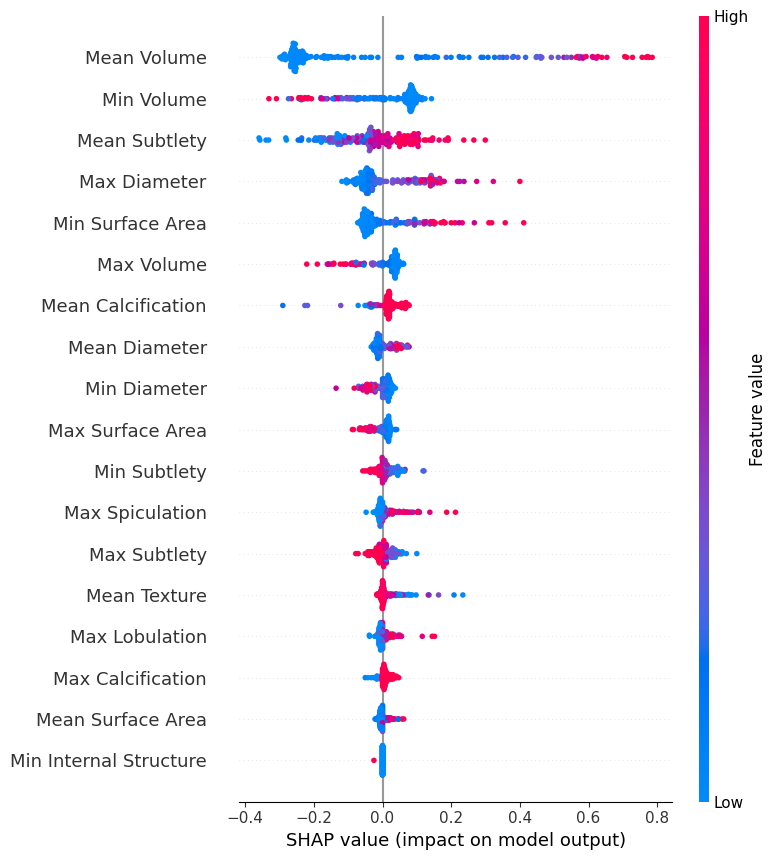

In [ ]:
# Reduce the sample size for X_test and background for quicker SHAP computation
X_test_sample = X_test.sample(200, random_state=42)
background_sample = X_train.sample(20, random_state=42)

# Initialize SHAP KernelExplainer with a smaller background sample
explainer = shap.KernelExplainer(best_svc.predict, background_sample)
shap_values = explainer.shap_values(X_test_sample)

# Visualize feature importance
feature_names = X_train.columns
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)

In [ ]:
svc_conf_matrix = confusion_matrix(y_test, best_svc.predict(X_test))
 
svc_class_report = classification_report(y_test, best_svc.predict(X_test))

svc_test_auc_roc = roc_auc_score(y_test, best_svc.predict(X_test))

precision, recall, _ = precision_recall_curve(y_test, best_svc.predict(X_test))
svc_pr_auc = auc(recall, precision)

svc_f1 = f1_score(y_test, best_svc.predict(X_test))

print("Confusion Matrix:")
print(svc_conf_matrix)
print("\n")
print("Classification Report:")
print(svc_class_report)
print("Test F1 Score:", svc_f1)
print("Test AUC-ROC Score:", svc_test_auc_roc)
print("Test PR AUC:", svc_pr_auc)

Confusion Matrix:
[[366  50]
 [ 15 100]]


Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.88      0.92       416
        True       0.67      0.87      0.75       115

    accuracy                           0.88       531
   macro avg       0.81      0.87      0.84       531
weighted avg       0.90      0.88      0.88       531

Test F1 Score: 0.7547169811320754
Test AUC-ROC Score: 0.8746864548494983
Test PR AUC: 0.7822402358142961


CNN without oversampling

## 5.4 Convolutional Neural Network without oversampling <a name="cnn"></a>
[[go back to the top]](#contents)

I train a lightweight **CNN** on per‑nodule feature sequences or image‑derived vectors **without oversampling**.
- **Inputs:** `X_train`, `y_train` arranged as required by the model (ensure the expected input shape).
- **Model & key hyperparameters:** Stack of convolutional + pooling layers followed by dense layers (see code for exact architecture). Use **EarlyStopping**/**ReduceLROnPlateau** if configured.
- **Validation & metrics:** Hold‑out validation; report **ROC‑AUC, F1, precision, recall**, plus loss/accuracy curves if available.
- **Outputs/artifacts:** Best epoch weights kept in memory; metrics and plots shown inline.
- **How to tweak:** Adjust `epochs`, `batch_size`, and layer widths; consider dropout for regularization.

[[go back to the top]](#contents)

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for CNN input
X_cnn = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# Split augmented data
X_cnn_train, X_cnn_test, y_cnn_train, y_cnn_test = train_test_split(X_cnn, y, test_size=0.2, random_state=42)

In [32]:
# CNN model
model = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', padding='same', input_shape=(X_cnn.shape[1], 1), kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile model
model.compile(optimizer=RMSprop(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=[F1Score(num_classes=1, average='micro')])

# Train model
model.fit(X_cnn_train, y_cnn_train, 
          epochs=100, 
          batch_size=64, 
          validation_data=(X_cnn_test, y_cnn_test), 
          callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
34/34 [==============================] - 3s 18ms/step - loss: 0.3515 - f1_score: 0.3431 - val_loss: 0.3952 - val_f1_score: 0.3560 - lr: 5.0000e-04
Epoch 2/100
34/34 [==============================] - 0s 7ms/step - loss: 0.3035 - f1_score: 0.3431 - val_loss: 0.3394 - val_f1_score: 0.3560 - lr: 5.0000e-04
Epoch 3/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2817 - f1_score: 0.3431 - val_loss: 0.2962 - val_f1_score: 0.3560 - lr: 5.0000e-04
Epoch 4/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2763 - f1_score: 0.3431 - val_loss: 0.2675 - val_f1_score: 0.3560 - lr: 5.0000e-04
Epoch 5/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2866 - f1_score: 0.3431 - val_loss: 0.2674 - val_f1_score: 0.3560 - lr: 5.0000e-04
Epoch 6/100
34/34 [==============================] - 0s 7ms/step - loss: 0.2658 - f1_score: 0.3431 - val_loss: 0.2614 - val_f1_score: 0.3560 - lr: 5.0000e-04
Epoch 7/100
34/34 [==============================] 

In [ ]:
cnn_conf_matrix = confusion_matrix(y_cnn_test, np.round(model.predict(X_cnn_test)))
 
cnn_class_report = classification_report(y_cnn_test, np.round(model.predict(X_cnn_test)))
 
cnn_test_auc_roc = roc_auc_score(y_cnn_test, model.predict(X_cnn_test))
 
precision, recall, _ = precision_recall_curve(y_cnn_test, model.predict(X_cnn_test))
cnn_pr_auc = auc(recall, precision)
 
cnn_f1 = f1_score(y_cnn_test, np.round(model.predict(X_cnn_test)))

print("Confusion Matrix:")
print(cnn_conf_matrix)
print("\n")
print("Classification Report:")
print(cnn_class_report)
print("Test F1 Score:", cnn_f1)
print("Test AUC-ROC Score:", cnn_test_auc_roc)
print("Test PR AUC:", cnn_pr_auc)

17/17 [==============================] - 0s 2ms/step
Confusion Matrix:
[[398  18]
 [ 32  83]]


Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.96      0.94       416
        True       0.82      0.72      0.77       115

    accuracy                           0.91       531
   macro avg       0.87      0.84      0.85       531
weighted avg       0.90      0.91      0.90       531

Test F1 Score: 0.7685185185185185
Test AUC-ROC Score: 0.9330476588628762
Test PR AUC: 0.8282676165963081


## 5.5 Ensemble Classifier without oversampling <a name="ec"></a>
[[go back to the top]](#contents)

I combine predictions from multiple base learners (e.g., RF, SVC, CNN) via **hard/soft voting**.
- **Inputs:** Fitted base models and their validation‑calibrated probabilities.
- **Model & key hyperparameters:** `VotingClassifier` (or custom averaging) with `voting='soft'` when probabilistic outputs are available.
- **Validation & metrics:** Compare ensemble against best single model on **ROC‑AUC, F1, precision, recall**.
- **Outputs/artifacts:** Aggregate metrics and confusion matrix displayed.
- **How to tweak:** Toggle member models or weights; try stacking with a meta‑learner for potential gains.

In [34]:
# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking ensemble
ensemble = StackingClassifier(
    estimators=[('svm', best_svc), ('rf', best_rf)],
    final_estimator=meta_model
)

# Fit the ensemble model
ensemble.fit(X_train, y_train)

StackingClassifier(estimators=[('svm',
                                SVC(C=0.1, class_weight='balanced',
                                    kernel='linear', random_state=42)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced_subsample',
                                                       max_depth=10,
                                                       min_samples_split=10,
                                                       n_estimators=200,
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
ec_conf_matrix = confusion_matrix(y_test, ensemble.predict(X_test))
 
ec_class_report = classification_report(y_test, ensemble.predict(X_test))
 
ec_test_auc_roc = roc_auc_score(y_test, ensemble.predict(X_test))

precision, recall, _ = precision_recall_curve(y_test, ensemble.predict(X_test))
ec_pr_auc = auc(recall, precision)
 
ec_f1 = f1_score(y_test, ensemble.predict(X_test))

print("Confusion Matrix:")
print(ec_conf_matrix)
print("\n")
print("Classification Report:")
print(ec_class_report)
print("Test F1 Score:", ec_f1)
print("Test AUC-ROC Score:", ec_test_auc_roc)
print("Test PR AUC:", ec_pr_auc)

Confusion Matrix:
[[395  21]
 [ 28  87]]


Classification Report:
              precision    recall  f1-score   support

       False       0.93      0.95      0.94       416
        True       0.81      0.76      0.78       115

    accuracy                           0.91       531
   macro avg       0.87      0.85      0.86       531
weighted avg       0.91      0.91      0.91       531

Test F1 Score: 0.7802690582959642
Test AUC-ROC Score: 0.8530204849498328
Test PR AUC: 0.8074039957422419


# 6. Classification with oversampling <a name="co"></a>
[[go back to the top]](#contents)

To address class imbalance, we apply SMOTE on the training features to synthesize minority examples. Each model is retrained on the resampled data (test set remains original), and we re-report all metrics to quantify the benefit/risk of oversampling.

In [36]:
# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit SMOTE to the data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(f"Resampled class distribution: {Counter(y_resampled)}")

Resampled class distribution: Counter({True: 1681, False: 1681})


## 6.1 Traditional Random Forest Classifier with oversampling <a name="rfo"></a>
[[go back to the top]](#contents)

I train **Random Forest** after **oversampling the minority class** (e.g., SMOTE configured earlier).
- **Inputs:** `X_resampled`, `y_resampled` produced by the oversampling step; evaluate on untouched `X_test`, `y_test`.
- **Model & key hyperparameters:** Grid over core RF hyperparameters as above; fit on resampled data.
- **Validation & metrics:** Report **ROC‑AUC, F1, precision, recall**, and confusion matrix; include SHAP feature importance.
- **Outputs/artifacts:** Best params and metrics printed; plots rendered inline.
- **How to tweak:** Adjust oversampling strategy (k‑neighbors) and RF depth/trees.

In [ ]:
rfo = RandomForestClassifier(random_state=42)

In [ ]:
param_grid = {
    'class_weight': ['balanced', 'balanced_subsample'],
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rfo = GridSearchCV(estimator=rfo, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1)
grid_search_rfo.fit(X_resampled, y_resampled)

best_rfo = grid_search_rfo.best_estimator_

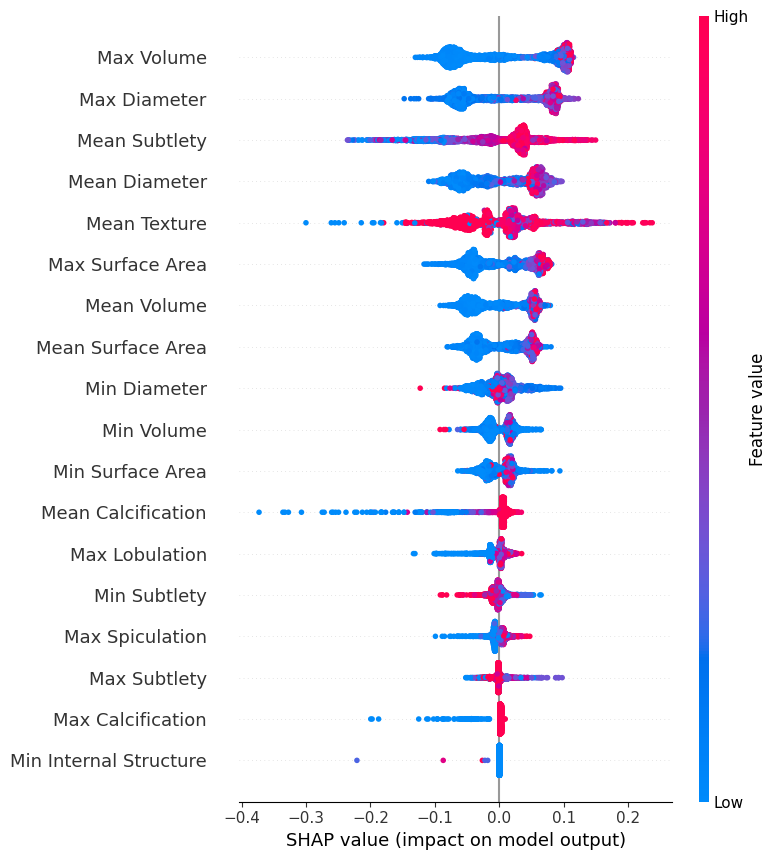

In [ ]:
explainer = shap.TreeExplainer(best_rfo)
shap_values = explainer.shap_values(X_resampled)

shap.summary_plot(shap_values[1], X_resampled, plot_type="dot", color=plt.get_cmap("coolwarm"))

In [ ]:
rfo_conf_matrix = confusion_matrix(y_test, best_rfo.predict(X_test))
 
rfo_class_report = classification_report(y_test, best_rfo.predict(X_test))
 
rfo_test_auc_roc = roc_auc_score(y_test, best_rfo.predict(X_test))
 
precision, recall, _ = precision_recall_curve(y_test, best_rfo.predict(X_test))
rfo_pr_auc = auc(recall, precision)
 
rfo_f1 = f1_score(y_test, best_rfo.predict(X_test))

print("Best parameters:", grid_search_rfo.best_params_)
print("\n")
print("Confusion Matrix:")
print(rfo_conf_matrix)
print("\n")
print("Classification Report:")
print(rfo_class_report)
print("Test F1 Score:", rfo_f1)
print("Test AUC-ROC Score:", rfo_test_auc_roc)
print("Test PR AUC:", rfo_pr_auc)

Best parameters: {'class_weight': 'balanced_subsample', 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}


Confusion Matrix:
[[378  38]
 [ 23  92]]


Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.91      0.93       416
        True       0.71      0.80      0.75       115

    accuracy                           0.89       531
   macro avg       0.83      0.85      0.84       531
weighted avg       0.89      0.89      0.89       531

Test F1 Score: 0.7510204081632654
Test AUC-ROC Score: 0.854326923076923
Test PR AUC: 0.7755034043169637


## 6.2 Balanced Random Forest Classifier with oversampling <a name="brfo"></a>
[[go back to the top]](#contents)

I fit **Balanced Random Forest** on **oversampled** training data to combine algorithmic re‑weighting with synthetic examples.
- **Inputs:** `X_resampled`, `y_resampled` from the oversampling step.
- **Model & key hyperparameters:** `BalancedRandomForestClassifier` with tuned `n_estimators`/`max_depth`.
- **Validation & metrics:** Evaluate on held‑out test set with **ROC‑AUC, F1, precision, recall**, and confusion matrix; analyze SHAP feature impacts.
- **Outputs/artifacts:** Best configuration and metrics displayed.
- **How to tweak:** Experiment with/without external oversampling (BRF already balances internally).

In [ ]:
brfo = BalancedRandomForestClassifier(random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False],
    'oob_score': [True, False],
    'sampling_strategy': ['auto', 0.5, 0.75, 1.0],
    'replacement': [True, False]
}

grid_search_brfo = GridSearchCV(estimator=brfo, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1)
grid_search_brfo.fit(X_resampled, y_resampled)

best_brfo = grid_search_brfo.best_estimator_


7680 fits failed out of a total of 12288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4608 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gui\anaconda3\envs\pyradiomics_env\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gui\anaconda3\envs\pyradiomics_env\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\Gui\anaconda3\envs\pyradiomics_env\lib\site-packages\imblearn\ensemble\_forest.py", line 749, in fit
    samplers_trees = Parallel(
  File "c:\Users\Gui\anaconda3\envs\pyradiomics_env\lib\site-packages\sklearn\ut

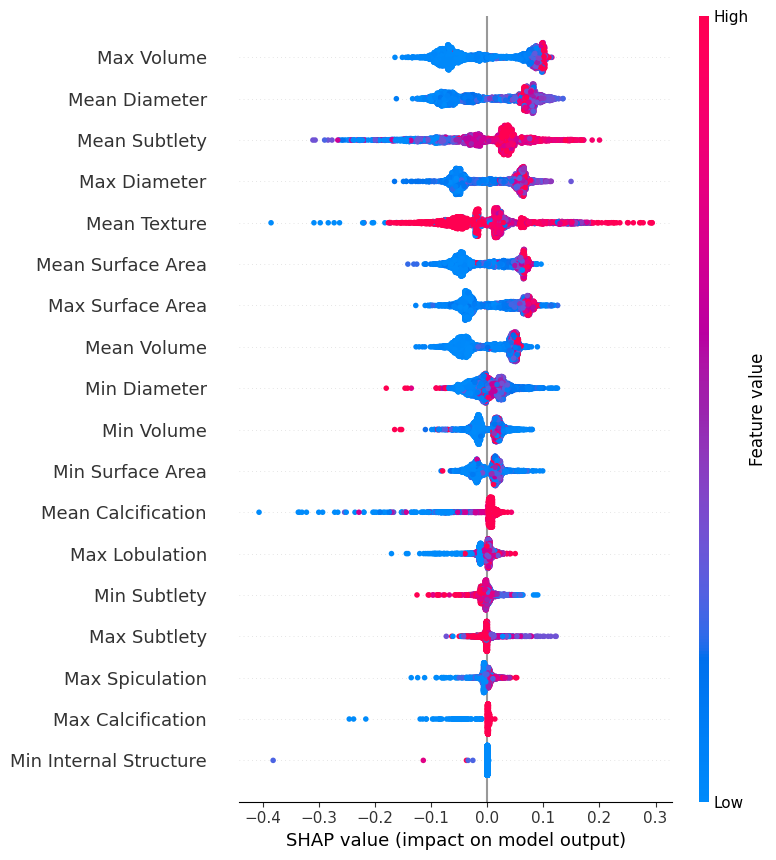

In [ ]:
explainer = shap.TreeExplainer(best_brfo)
shap_values = explainer.shap_values(X_resampled)

shap.summary_plot(shap_values[1], X_resampled, plot_type="dot", color=plt.get_cmap("coolwarm"))

In [ ]:
brfo_conf_matrix = confusion_matrix(y_test, best_brfo.predict(X_test))
 
brfo_class_report = classification_report(y_test, best_brfo.predict(X_test))
 
brfo_test_auc_roc = roc_auc_score(y_test, best_brfo.predict(X_test))
 
precision, recall, _ = precision_recall_curve(y_test, best_brfo.predict(X_test))
brfo_pr_auc = auc(recall, precision)
 
brfo_f1 = f1_score(y_test, best_brfo.predict(X_test))

print("Best parameters:", grid_search_brfo.best_params_)
print("\n")
print("Confusion Matrix:")
print(brfo_conf_matrix)
print("\n")
print("Classification Report:")
print(brfo_class_report)
print("Test F1 Score:", brfo_f1)
print("Test AUC-ROC Score:", brfo_test_auc_roc)
print("Test PR AUC:", brfo_pr_auc)

Best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200, 'oob_score': False, 'replacement': False, 'sampling_strategy': 'auto'}


Confusion Matrix:
[[385  31]
 [ 26  89]]


Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.93      0.93       416
        True       0.74      0.77      0.76       115

    accuracy                           0.89       531
   macro avg       0.84      0.85      0.84       531
weighted avg       0.89      0.89      0.89       531

Test F1 Score: 0.7574468085106384
Test AUC-ROC Score: 0.849696906354515
Test PR AUC: 0.7822719643003357


## 6.3 Support Vector Classifier with oversampling <a name="svco"></a>
[[go back to the top]](#contents)

I train **SVC** after **oversampling** to alleviate class imbalance in the margin.
- **Inputs:** `X_resampled`, `y_resampled` for training; evaluation on original `X_test`, `y_test`.
- **Model & key hyperparameters:** Grid over `C`, `gamma`, and kernel; standardize features before fitting.
- **Validation & metrics:** Report **ROC‑AUC, F1, precision, recall**; include confusion matrix.
- **Outputs/artifacts:** Best hyperparameters and metrics printed.
- **How to tweak:** Tune SMOTE `k_neighbors` and SVC `C`/`gamma` for better minority recall.

In [ ]:
svco = SVC(random_state=42)

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf'],
    'class_weight': ['balanced']
}

grid_search_svco = GridSearchCV(estimator=svco, param_grid=param_grid, cv=skf, scoring='f1', n_jobs=-1, verbose=2)
grid_search_svco.fit(X_resampled, y_resampled)

best_svco = grid_search_svco.best_estimator_
print("Best parameters:", grid_search_svco.best_params_)

Fitting 8 folds for each of 12 candidates, totalling 96 fits
Best parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'linear'}


  0%|          | 0/200 [00:00<?, ?it/s]

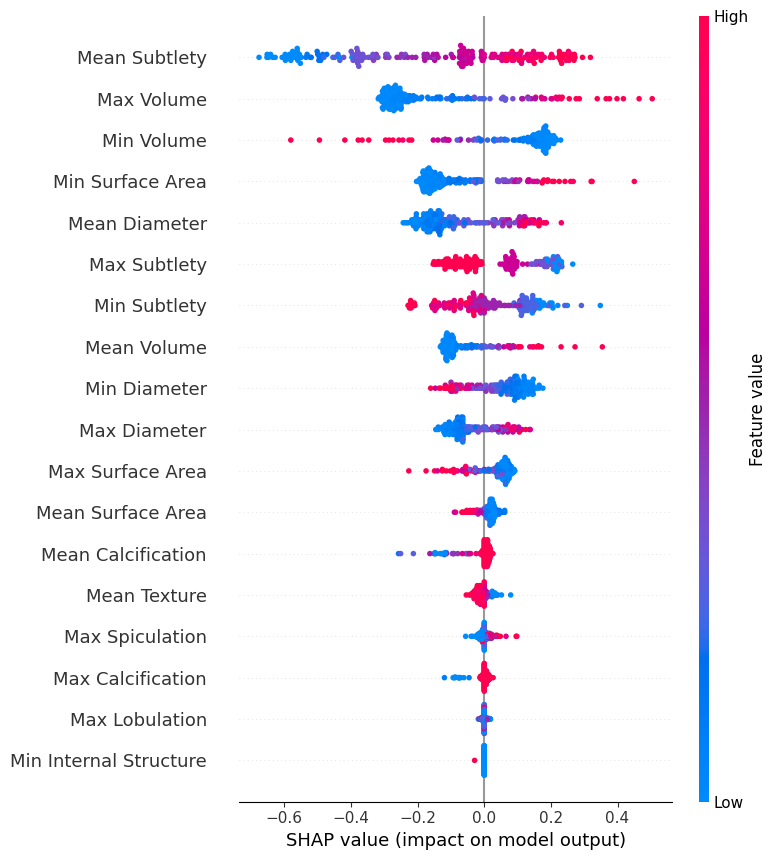

In [47]:
# Reduce the sample size for X_test and background for quicker SHAP computation
X_test_sample = X_test.sample(200, random_state=42)
background_sample = X_resampled.sample(20, random_state=42)

# Initialize SHAP KernelExplainer with a smaller background sample
explainer = shap.KernelExplainer(best_svco.predict, background_sample)

# Calculate SHAP values only for the smaller X_test sample
shap_values = explainer.shap_values(X_test_sample)

# Visualize feature importance
feature_names = X_resampled.columns
shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names)

In [ ]:
svco_conf_matrix = confusion_matrix(y_test, best_svco.predict(X_test))

svco_class_report = classification_report(y_test, best_svco.predict(X_test))
 
svco_test_auc_roc = roc_auc_score(y_test, best_svco.predict(X_test))
 
precision, recall, _ = precision_recall_curve(y_test, best_svc.predict(X_test))
svco_pr_auc = auc(recall, precision)
 
svco_f1 = f1_score(y_test, best_svco.predict(X_test))

print("Confusion Matrix:")
print(svco_conf_matrix)
print("\n")
print("Classification Report:")
print(svco_class_report)
print("Test F1 Score:", svco_f1)
print("Test AUC-ROC Score:", svco_test_auc_roc)
print("Test PR AUC:", svco_pr_auc)

Confusion Matrix:
[[369  47]
 [ 23  92]]


Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.89      0.91       416
        True       0.66      0.80      0.72       115

    accuracy                           0.87       531
   macro avg       0.80      0.84      0.82       531
weighted avg       0.88      0.87      0.87       531

Test F1 Score: 0.7244094488188976
Test AUC-ROC Score: 0.8435096153846153
Test PR AUC: 0.7822402358142961


## 6.4 Convolutional Neural Network with oversampling <a name="cnno"></a>
[[go back to the top]](#contents)

I train **CNN** on **oversampled** training data (sequence/image vectors) to balance classes during learning.
- **Inputs:** `X_resampled`, `y_resampled` shaped for the network; test on `X_test`, `y_test`.
- **Model & key hyperparameters:** Convolutional + pooling blocks with dense head; consider class‑weighted loss in addition to oversampling.
- **Validation & metrics:** Track **ROC‑AUC, F1, precision, recall** on validation/test; visualize training curves.
- **Outputs/artifacts:** Metrics and plots rendered inline.
- **How to tweak:** Adjust architecture depth and early‑stopping patience; try data augmentation if using images.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

X_cnno = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

X_cnno_train, X_cnno_test, y_cnno_train, y_cnno_test = train_test_split(X_cnno, y_resampled, test_size=0.2, random_state=42)

In [50]:
# CNN model
modelo = Sequential([
    Conv1D(16, kernel_size=3, activation='relu', padding='same', input_shape=(X_cnno.shape[1], 1), kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu', padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Compile model
modelo.compile(optimizer=RMSprop(learning_rate=0.0005), 
              loss='binary_crossentropy', 
              metrics=[F1Score(num_classes=1, average='micro')])

# Train model
modelo.fit(X_cnno_train, y_cnno_train, 
          epochs=100, 
          batch_size=64, 
          validation_data=(X_cnno_test, y_cnno_test), 
          callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
43/43 [==============================] - 2s 12ms/step - loss: 0.4496 - f1_score: 0.6695 - val_loss: 0.4475 - val_f1_score: 0.6553 - lr: 5.0000e-04
Epoch 2/100
43/43 [==============================] - 0s 6ms/step - loss: 0.3720 - f1_score: 0.6695 - val_loss: 0.3945 - val_f1_score: 0.6553 - lr: 5.0000e-04
Epoch 3/100
43/43 [==============================] - 0s 7ms/step - loss: 0.3530 - f1_score: 0.6695 - val_loss: 0.3599 - val_f1_score: 0.6553 - lr: 5.0000e-04
Epoch 4/100
43/43 [==============================] - 0s 6ms/step - loss: 0.3445 - f1_score: 0.6695 - val_loss: 0.3426 - val_f1_score: 0.6553 - lr: 5.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 14ms/step - loss: 0.3301 - f1_score: 0.6695 - val_loss: 0.3262 - val_f1_score: 0.6553 - lr: 5.0000e-04
Epoch 6/100
43/43 [==============================] - 0s 6ms/step - loss: 0.3136 - f1_score: 0.6695 - val_loss: 0.3378 - val_f1_score: 0.6553 - lr: 5.0000e-04
Epoch 7/100
43/43 [==============================]

In [ ]:
cnno_conf_matrix = confusion_matrix(y_cnn_test, np.round(modelo.predict(X_cnn_test)))

cnno_class_report = classification_report(y_cnn_test, np.round(modelo.predict(X_cnn_test)))
 
cnno_test_auc_roc = roc_auc_score(y_cnn_test, modelo.predict(X_cnn_test))
 
precision, recall, _ = precision_recall_curve(y_cnn_test, modelo.predict(X_cnn_test))
cnno_pr_auc = auc(recall, precision)
 
cnno_f1 = f1_score(y_cnn_test, np.round(modelo.predict(X_cnn_test)))

print("Confusion Matrix:")
print(cnno_conf_matrix)
print("\n")
print("Classification Report:")
print(cnno_class_report)
print("Test F1 Score:", cnno_f1)
print("Test AUC-ROC Score:", cnno_test_auc_roc)
print("Test PR AUC:", cnno_pr_auc)

17/17 [==============================] - 0s 2ms/step
Confusion Matrix:
[[311 105]
 [ 13 102]]


Classification Report:
              precision    recall  f1-score   support

       False       0.96      0.75      0.84       416
        True       0.49      0.89      0.63       115

    accuracy                           0.78       531
   macro avg       0.73      0.82      0.74       531
weighted avg       0.86      0.78      0.80       531

Test F1 Score: 0.6335403726708075
Test AUC-ROC Score: 0.9097826086956522
Test PR AUC: 0.8130788562877065


## 6.5 Ensemble Classifier with oversampling <a name="ec"></a>
[[go back to the top]](#contents)

I build an **ensemble** over models trained with oversampling to see if balanced learners complement each other.
- **Inputs:** Calibrated probabilities from oversampled RF/SVC/CNN variants.
- **Model & key hyperparameters:** Soft voting (or weighted averaging) of class probabilities.
- **Validation & metrics:** Compare to the best single oversampled model on **ROC‑AUC, F1, precision, recall**.
- **Outputs/artifacts:** Ensemble metrics and confusion matrix displayed.
- **How to tweak:** Adjust member weights; try stacking with logistic regression as a meta‑classifier.

[[go back to the top]](#contents)

In [56]:
# Define the meta-model
meta_model = LogisticRegression()

# Create the stacking ensemble
ensemble = StackingClassifier(
    estimators=[('svm', best_svc), ('rf', best_rf)],
    final_estimator=meta_model
)

# Fit the ensemble model
ensemble.fit(X_resampled, y_resampled)

StackingClassifier(estimators=[('svm',
                                SVC(C=0.1, class_weight='balanced',
                                    kernel='linear', random_state=42)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced_subsample',
                                                       max_depth=10,
                                                       min_samples_split=10,
                                                       n_estimators=200,
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

In [ ]:
eco_conf_matrix = confusion_matrix(y_test, ensemble.predict(X_test))
 
eco_class_report = classification_report(y_test, ensemble.predict(X_test))
 
eco_test_auc_roc = roc_auc_score(y_test, ensemble.predict(X_test))
 
precision, recall, _ = precision_recall_curve(y_test, ensemble.predict(X_test))
eco_pr_auc = auc(recall, precision)
 
eco_f1 = f1_score(y_test, ensemble.predict(X_test))

print("Confusion Matrix:")
print(eco_conf_matrix)
print("\n")
print("Classification Report:")
print(eco_class_report)
print("Test F1 Score:", eco_f1)
print("Test AUC-ROC Score:", eco_test_auc_roc)
print("Test PR AUC:", eco_pr_auc)

Confusion Matrix:
[[376  40]
 [ 23  92]]


Classification Report:
              precision    recall  f1-score   support

       False       0.94      0.90      0.92       416
        True       0.70      0.80      0.74       115

    accuracy                           0.88       531
   macro avg       0.82      0.85      0.83       531
weighted avg       0.89      0.88      0.88       531

Test F1 Score: 0.7449392712550608
Test AUC-ROC Score: 0.8519230769230769
Test PR AUC: 0.7701420989556583


# 7. Models Comparison <a name="comparison"></a>
[[go back to the top]](#contents)

We synthesize results across all ten models (five without SMOTE, five with SMOTE) using bar charts for F1, ROC-AUC, and PR-AUC, plus averaged scores that pair each model’s SMOTE/no-SMOTE variants. Crosstabs compare prediction agreement between each pair (e.g., RF vs RF+SMOTE) to reveal systematic shifts due to resampling.



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



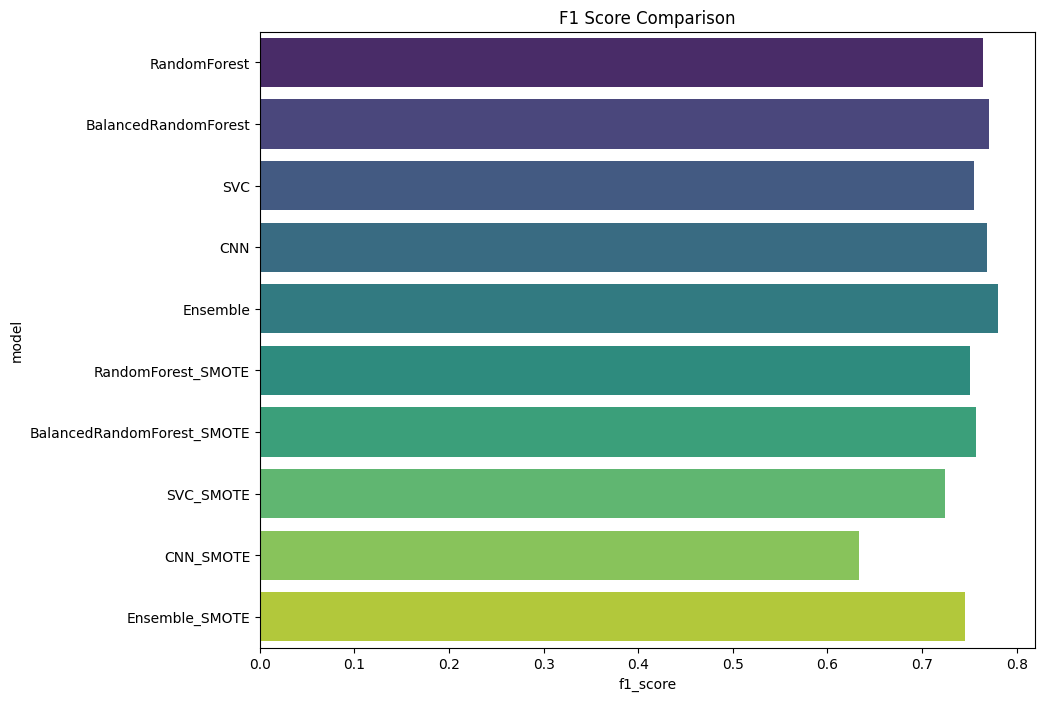

In [ ]:
#F1 score models comparison
f1 = {'f1_score': [rf_f1, brf_f1, svc_f1, cnn_f1, ec_f1, rfo_f1, brfo_f1, svco_f1, cnno_f1, eco_f1],
        'model': ['RandomForest', 'BalancedRandomForest', 'SVC', 'CNN', 'Ensemble', 'RandomForest_SMOTE', 'BalancedRandomForest_SMOTE', 'SVC_SMOTE', 'CNN_SMOTE', 'Ensemble_SMOTE']}
data = pd.DataFrame(f1)
plt.figure(figsize=(10, 8))
sns.barplot(x='f1_score', y='model', data=data, palette='viridis')
plt.title('F1 Score Comparison')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



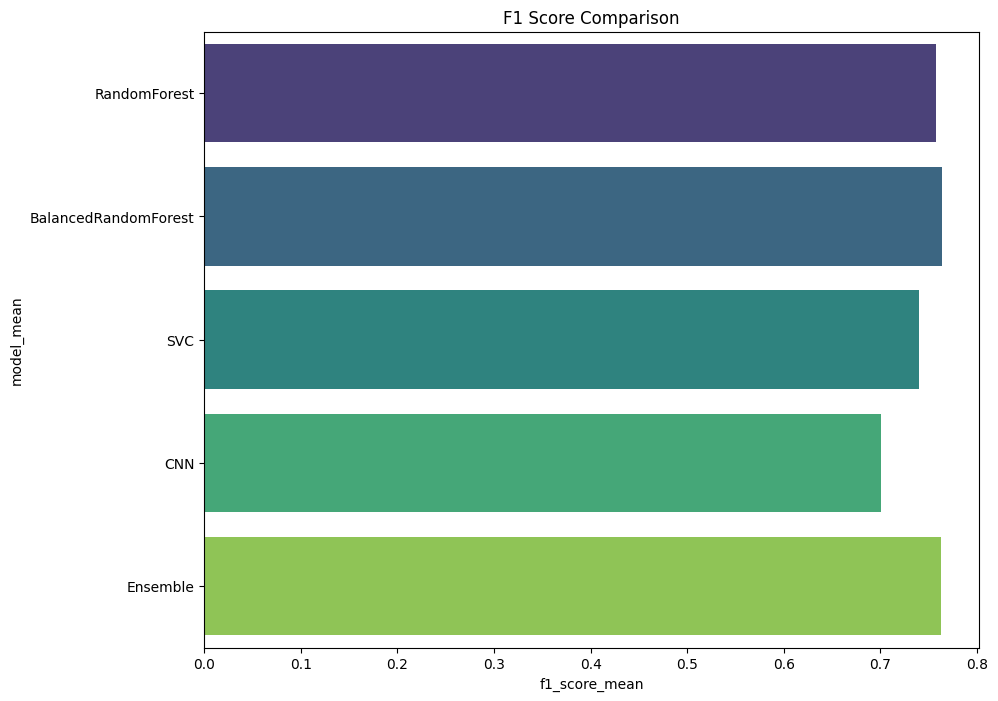

In [ ]:
#F1 score models comparison
f1_mean = {'f1_score_mean': [np.mean([rf_f1, rfo_f1]), np.mean([brf_f1, brfo_f1]), np.mean([svc_f1, svco_f1]), np.mean([cnn_f1, cnno_f1]), np.mean([ec_f1, eco_f1])],
        'model_mean': ['RandomForest', 'BalancedRandomForest', 'SVC', 'CNN', 'Ensemble']}
data = pd.DataFrame(f1_mean)
plt.figure(figsize=(10, 8))
sns.barplot(x='f1_score_mean', y='model_mean', data=data, palette='viridis')
plt.title('F1 Score Comparison')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



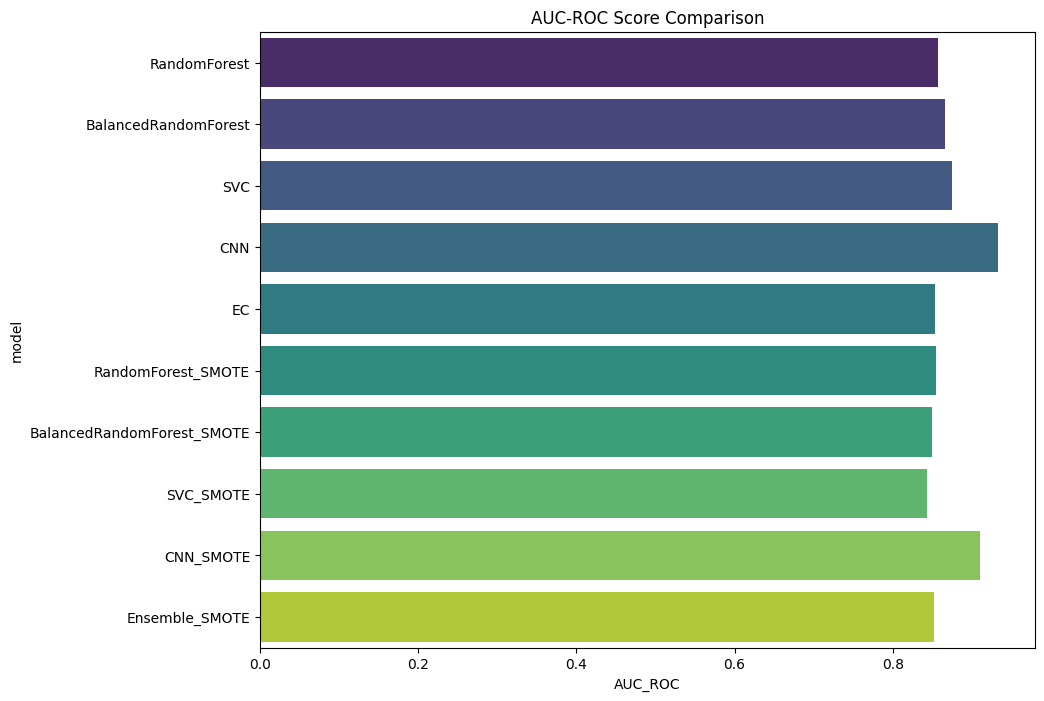

In [ ]:
#AUC-ROC score models comparison
AUC_ROC = {'AUC_ROC': [rf_test_auc_roc, brf_test_auc_roc, svc_test_auc_roc, cnn_test_auc_roc, ec_test_auc_roc, rfo_test_auc_roc, brfo_test_auc_roc, svco_test_auc_roc, cnno_test_auc_roc, eco_test_auc_roc],
        'model': ['RandomForest', 'BalancedRandomForest', 'SVC', 'CNN', 'EC', 'RandomForest_SMOTE', 'BalancedRandomForest_SMOTE', 'SVC_SMOTE', 'CNN_SMOTE', 'Ensemble_SMOTE']}
data = pd.DataFrame(AUC_ROC)
plt.figure(figsize=(10, 8))
sns.barplot(x='AUC_ROC', y='model', data=data, palette='viridis')
plt.title('AUC-ROC Score Comparison')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



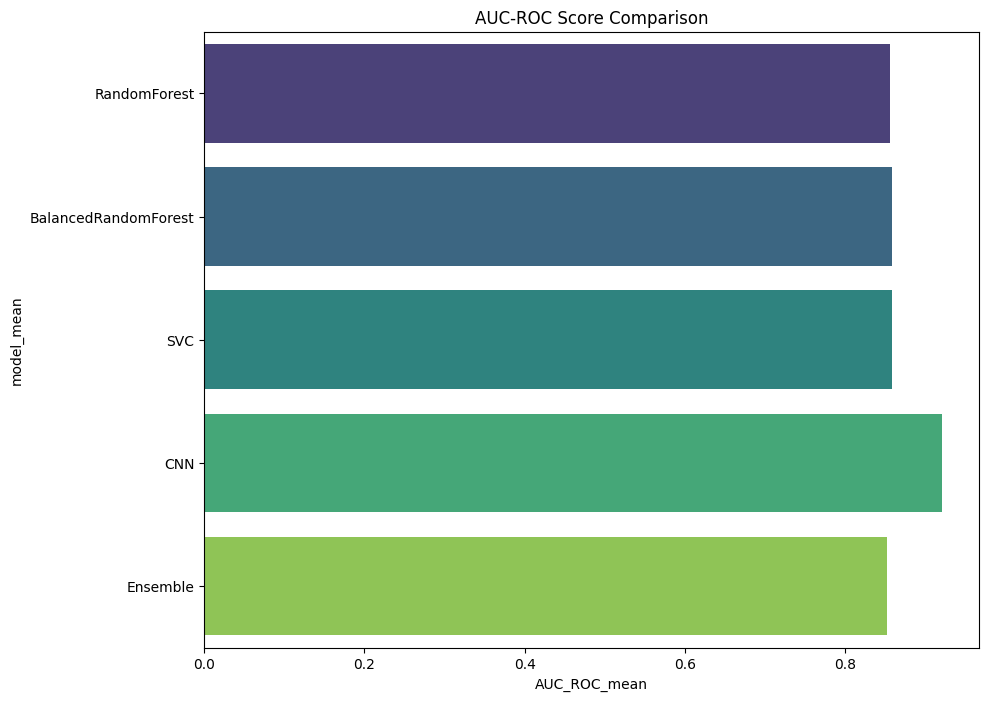

In [ ]:
#AUC-ROC score models comparison
AUC_ROC_mean = {'AUC_ROC_mean': [np.mean([rf_test_auc_roc, rfo_test_auc_roc]), np.mean([brf_test_auc_roc, brfo_test_auc_roc]), np.mean([svc_test_auc_roc, svco_test_auc_roc]), np.mean([cnn_test_auc_roc, cnno_test_auc_roc]), np.mean([ec_test_auc_roc, eco_test_auc_roc])],
        'model_mean': ['RandomForest', 'BalancedRandomForest', 'SVC', 'CNN', 'Ensemble']}
data = pd.DataFrame(AUC_ROC_mean)
plt.figure(figsize=(10, 8))
sns.barplot(x='AUC_ROC_mean', y='model_mean', data=data, palette='viridis')
plt.title('AUC-ROC Score Comparison')
plt.show()




Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



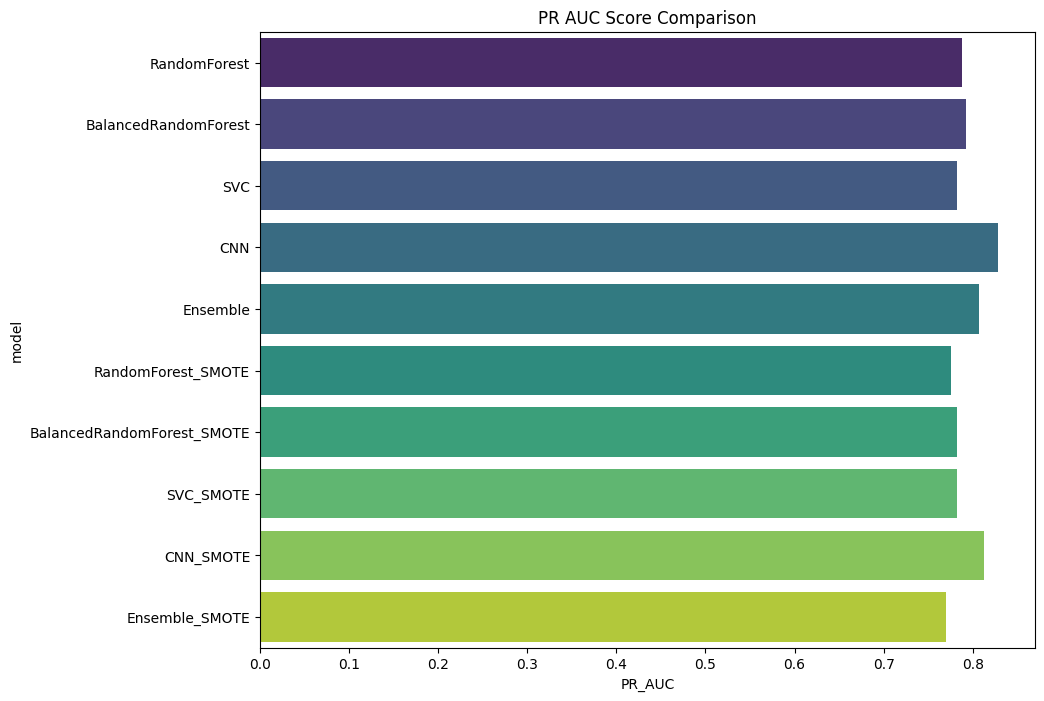

In [ ]:
#PR AUC score models comparison
PR_AUC = {'PR_AUC': [rf_pr_auc, brf_pr_auc, svc_pr_auc, cnn_pr_auc, ec_pr_auc, rfo_pr_auc, brfo_pr_auc, svco_pr_auc, cnno_pr_auc, eco_pr_auc],
        'model': ['RandomForest', 'BalancedRandomForest', 'SVC', 'CNN', 'Ensemble', 'RandomForest_SMOTE', 'BalancedRandomForest_SMOTE', 'SVC_SMOTE', 'CNN_SMOTE', 'Ensemble_SMOTE']}
data = pd.DataFrame(PR_AUC)
plt.figure(figsize=(10, 8))
sns.barplot(x='PR_AUC', y='model', data=data, palette='viridis')
plt.title('PR AUC Score Comparison')
plt.show()



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



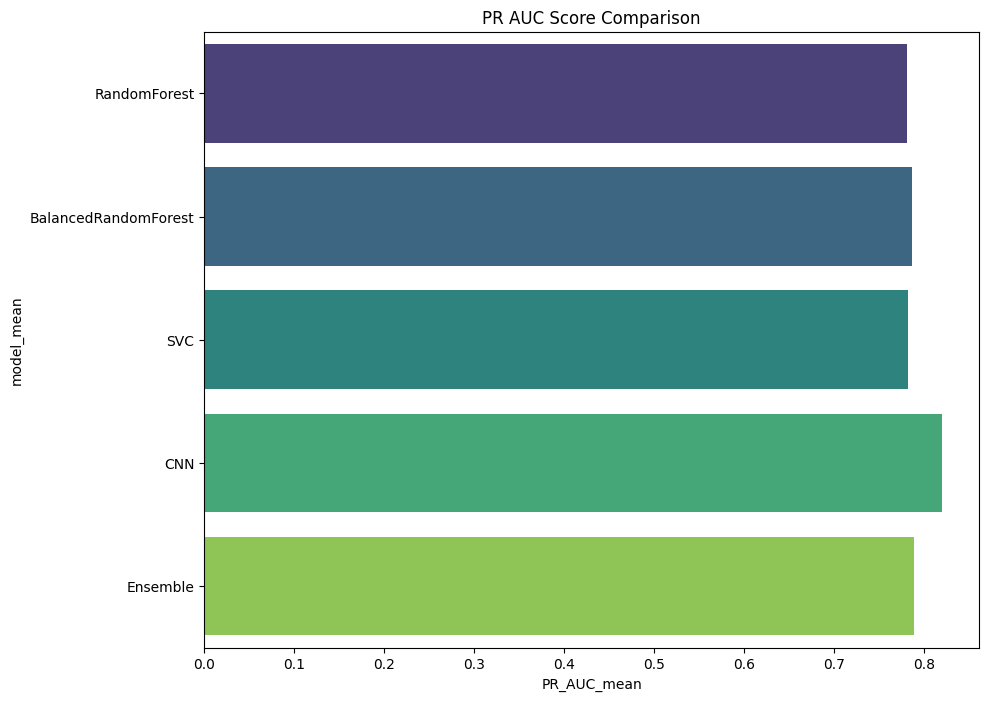

In [ ]:
#PR AUC score models comparison
PR_AUC_mean = {'PR_AUC_mean': [np.mean([rf_pr_auc, rfo_pr_auc]), np.mean([brf_pr_auc, brfo_pr_auc]), np.mean([svc_pr_auc, svco_pr_auc]), np.mean([cnn_pr_auc, cnno_pr_auc]), np.mean([ec_pr_auc, eco_pr_auc])],
        'model_mean': ['RandomForest', 'BalancedRandomForest', 'SVC', 'CNN', 'Ensemble']}
data = pd.DataFrame(PR_AUC_mean)
plt.figure(figsize=(10, 8))
sns.barplot(x='PR_AUC_mean', y='model_mean', data=data, palette='viridis')
plt.title('PR AUC Score Comparison')
plt.show()


In [64]:
# The following corss tables show the differences between the models predictions
pd.crosstab(best_rf.predict(X_test), best_rfo.predict(X_test), rownames=['Random Forest'], colnames=['Random Forest SMOTE'])

Random Forest SMOTE,False,True
Random Forest,,
False,396,12
True,5,118


In [65]:
pd.crosstab(best_brf.predict(X_test), best_brfo.predict(X_test), rownames=['Balanced Random Forest'], colnames=['Balanced Random Forest SMOTE'])

Balanced Random Forest SMOTE,False,True
Balanced Random Forest,,
False,398,4
True,13,116


In [66]:
pd.crosstab(best_svc.predict(X_test), best_svco.predict(X_test), rownames=['SVC'], colnames=['SVC SMOTE'])

SVC SMOTE,False,True
SVC,,
False,372,9
True,20,130


In [67]:
pd.crosstab(np.round(model.predict(X_cnn_test)).astype(int).ravel(), np.round(modelo.predict(X_cnn_test)).astype(int).ravel(), rownames=['CNN'], colnames=['CNN SMOTE'])

17/17 [==============================] - 0s 1ms/step


CNN SMOTE,0,1
CNN,,
0,324,106
1,0,101


In [68]:
pd.crosstab(ensemble.predict(X_test), ensemble.predict(X_test), rownames=['Ensemble'], colnames=['Ensemble SMOTE'])

Ensemble SMOTE,False,True
Ensemble,,
False,399,0
True,0,132


# 8. Conclusion <a name="conclusion"></a>
[[go back to the top]](#contents)

Across 531 nodules (115 malignant), the models separate malignant from benign lesions reliably, but with clear trade-offs between ranking power, class balance, and sensitivity:

Best balanced performance: The stacking ensemble delivers the strongest overall balance of precision and recall (F1≈0.78, ROC-AUC≈0.85, PR-AUC≈0.81), making it a solid default when you want dependable screening without an explosion of false positives.

Robust alternative: Balanced Random Forest is nearly as strong (F1≈0.77, ROC-AUC≈0.87, PR-AUC≈0.79) and more stable to class imbalance, which is attractive for routine use and interpretability.

Best ranking ability: The CNN achieves the highest ranking metrics (ROC-AUC≈0.93, PR-AUC≈0.83) with F1≈0.77—excellent when you plan to set thresholds later or use scores to prioritize radiologist review queues.

Effect of oversampling: Oversampling raises recall for malignancy (e.g., CNN recall ≈0.89 vs 0.72 without) but cuts precision (≈0.49), dropping F1 to ≈0.63. Use it only if minimizing missed cancers is worth more downstream reads.